# Health Equity Among Home Care Aides

In order to conduct our analysis, we used medical insurance claims data from home care aides. Our data covered the years 2016, 2017, and 2018 and was sourced from Kaiser WA. We ended up with 1,824,238 total claims

For our analysis, we focused on 10 chronic conditions:
    
    * Diabetes
    * Hypertension
    * Obesity
    * Cancer
    * Musculoskeletal conditions
    * Cardiovascular conditions
    * Asthma
    * Chronic Obstructive Pulmonary Disorder (COPD)
    * Cholesterol
    * Mental health disorders

In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [4]:
med = pd.read_csv('../../data/reshaped_med.csv')
enroll = pd.read_csv('../../data/enroll.csv')

## What is the prevalence of the different chronic conditions of interest by year?

### Total number of HCAs each year

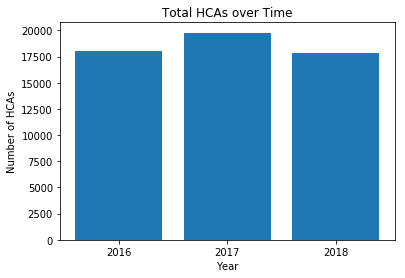

In [5]:
years = enroll.groupby(['Incurred Year']).agg({'Member ID Encrypted': 'count', 'Member ID Encrypted': 'nunique'})
years.reset_index(level=0, inplace=True)
years.columns = ['year', 'total']
years.loc[:, 'year'] = ['2016', '2017', '2018']
plt.bar(years['year'], years['total'])
plt.title('Total HCAs over Time')
plt.xlabel("Year")
plt.ylabel("Number of HCAs")
plt.show()

### Total number of claims each year

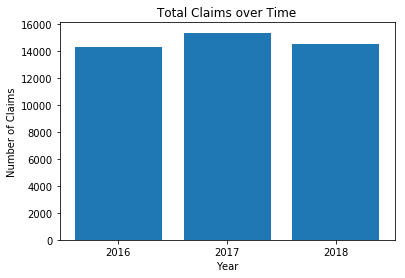

In [6]:
num_claims = med.groupby(['year']).size().reset_index(name='total')
num_claims.loc[:, 'year'] = ['2016', '2017', '2018']
plt.bar(num_claims['year'], num_claims['total'])
plt.title('Total Claims over Time')
plt.xlabel("Year")
plt.ylabel("Number of Claims")
plt.show()

In [7]:
asthma = med.groupby(['year'])['binary_asthma'].sum().reset_index(name ='asthma').asthma
bp = med.groupby(['year'])['binary_bp'].sum().reset_index(name ='bp').bp
cancer = med.groupby(['year'])['binary_cancer'].sum().reset_index(name = 'cancer').cancer
cardiovascular = med.groupby(['year'])['binary_cardiovascular'].sum().reset_index(name = 
                                                                                  'cardiovascular').cardiovascular
copd = med.groupby(['year'])['binary_copd'].sum().reset_index(name = 'copd').copd
diabetes = med.groupby(['year'])['binary_diabetes'].sum().reset_index(name = 'diabetes').diabetes
kidney = med.groupby(['year'])['binary_kidney'].sum().reset_index(name = 'kidney').kidney
obesity = med.groupby(['year'])['binary_obesity'].sum().reset_index(name = 'obesity').obesity
musculoskeletal = med.groupby(['year'])['binary_musculoskeletal'].sum().reset_index(name = 
                                                                                    'musculoskeletal').musculoskeletal
cholesterol = med.groupby(['year'])['binary_cholesterol'].sum().reset_index(name = 'cholesterol').cholesterol
mental_disorder = med.groupby(['year'])['binary_mental_disorder'].sum().reset_index(name = 
                                                                                    'mental_disorder').mental_disorder
totals_by_year = pd.concat([years, asthma, bp, cancer, cardiovascular, copd, diabetes, kidney, obesity, musculoskeletal, 
          cholesterol, mental_disorder], axis=1)
totals_by_year['chronic_total']= totals_by_year.iloc[:, 2:12].sum(axis=1)
percentages = totals_by_year.iloc[:,2:13].div(totals_by_year['total'], axis=0) * 100
percentages.loc[:, 'year'] = ['2016', '2017', '2018']
percentages_chronic = totals_by_year.iloc[:,2:13].div(totals_by_year['chronic_total'], axis=0) * 100
percentages_chronic.loc[:, 'year'] = ['2016', '2017', '2018']

### Top 3 most prevalent chronic disease

In [8]:
def disease_graph(disease): 
    plt.bar(percentages['year'], percentages[disease], align='center', color='tab:blue')
    plt.title('Prevalence of Asthma in HCA population')
    plt.xlabel("Year")
    plt.ylabel("Prevalence")
    plt.show()

    plt.bar(percentages_chronic['year'], percentages_chronic[disease], align='center', color='tab:blue')
    plt.title('Prevalence of Asthma HCA population with Chronic Diseases')
    plt.xlabel("Year")
    plt.ylabel("Prevalence")
    plt.show()
    return;

#### Blood Pressure

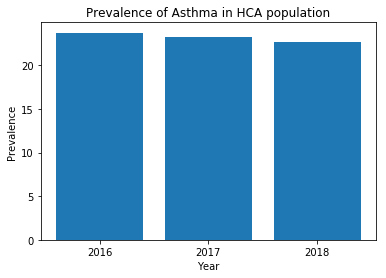

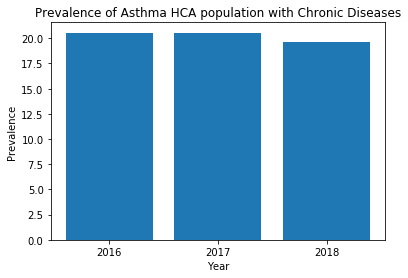

In [9]:
disease_graph('bp')

#### Cholesterol

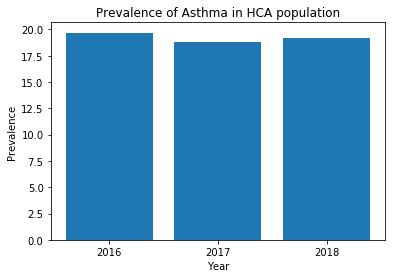

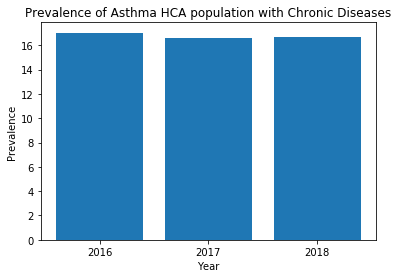

In [11]:
disease_graph('cholesterol')

#### Diabetes

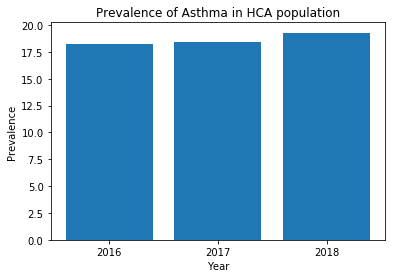

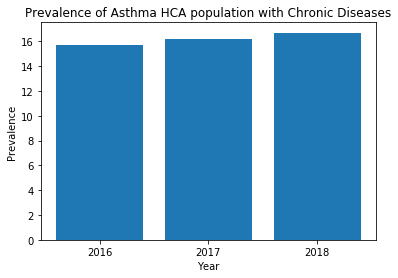

In [10]:
disease_graph('diabetes')

## What is the rate of co-morbidity in the population?

The comorbidity rate was calculated by taking dividing the number of HCAs with 2 or more chronic conditions of interest by HCAs with at least 1 chonic condition of interest. The comorbidity rate over all 3 years (2016-2018) was ~66%. This means that ~66% of HCAs with chronic conditions of interest have 2 or more of those conditions.

In [4]:
# Group by member id
member_groups = med.groupby(['member_id'])
comorbid = 0
at_least_one_condition = 0

# Loop through groups to count members
for mg_id, mg in member_groups:
    if any(mg['flag_comorbidity'] == 1):
        comorbid += 1
    if any(mg['total_conditions'] >= 1):
        at_least_one_condition += 1
        
comorbidity_rate = comorbid/at_least_one_condition
print('Commorbidity rate: ', comorbidity_rate)

Commorbidity rate:  0.6565615185033457


## What are the most common comorbidities in our claims data?

For this question, we chose to focus on HCAs with at least 1 chronic condition of interest. Taking a look at the distribution of total conditions in our data, we can see that the mean total number of conditions is 2 and the max total number of conditions is 6. There are several outliers at 7, 8, 9, and 10 total conditions.

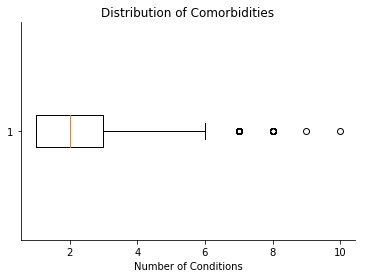

In [6]:
with_condition = med.loc[med['total_conditions'] > 0]
condition_count = with_condition.groupby('member_id').agg({'total_conditions':'max'})[['total_conditions']].reset_index()

ax = plt.subplot()
ax.boxplot(condition_count['total_conditions'], vert=False)
ax.set_xlabel('Number of Conditions')
ax.set_title('Distribution of Comorbidities')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:
cols = ['member_id', 'binary_asthma', 'binary_bp', 'binary_cancer', 'binary_cardiovascular', 'binary_cholesterol', 'binary_copd', 'binary_diabetes', 'binary_kidney', 'binary_mental_disorder', 'binary_musculoskeletal', 'binary_obesity', 'flag_comorbidity']
comorbid_count = med[cols]
comorbid_count = with_condition.groupby('member_id').agg({'binary_asthma':'max', 'binary_bp':'max', 'binary_cancer':'max', 'binary_cardiovascular':'max', 'binary_cholesterol':'max', 'binary_copd':'max', 'binary_diabetes':'max', 'binary_kidney':'max', 'binary_mental_disorder':'max', 'binary_musculoskeletal':'max', 'binary_obesity':'max', 'flag_comorbidity':'max'})

In [18]:
conditions = ['kidney', 'mental_disorder', 'bp', 'cardiovascular', 'diabetes', 'obesity', 'cancer', 'musculoskeletal', 'copd', 'cholesterol']

In [15]:
def combination(condition):
    # Get all rows with at least 2 conditions
    comorbid = comorbid_count.loc[comorbid_count['flag_comorbidity'] == 1]
    
    # Get rows with and without given condition
    with_condition = comorbid.loc[comorbid_count['binary_' + condition] == 1]
    without_condition = comorbid.loc[comorbid_count['binary_' + condition] == 0]
    
    # Count members (with 2+ conditions) with given condition who also have other conditions of interest
    with_condition_counts = with_condition.groupby('member_id', as_index=False).apply(count_conditions)
    with_condition_counts = with_condition_counts.sum(axis=0)
    
    # Count members (with 2+ conditions) without given condition who have other conditions of interest
    without_condition_counts = without_condition.groupby('member_id', as_index=False).apply(count_conditions)
    without_condition_counts = without_condition_counts.sum(axis=0)
    
    # Lists for chi2 values, p-values, and number of members with both the given condition
    # and the current condition of interest
    chi2 = []
    p = []
    num_both = []
    
    # Calculate chi2 for each condition of interest in relation to given condition
    for c in conditions:
        both = with_condition_counts[c]
        condition_without_c = with_condition_counts[condition] - both
        without_condition_with_c = without_condition_counts[c]
        without_condition_without_c = len(without_condition) - without_condition_with_c
        
        c_arr = np.array([[both, condition_without_c], [without_condition_with_c, without_condition_without_c]])
        c_chi2, c_p, c_dof, c_ex= stats.chi2_contingency(c_arr)
        chi2.append(c_chi2)
        p.append(c_p)
        num_both.append(both)
    
    comorbidity_dict = {'conditions': conditions, 'chi2': chi2, 'p_value': p, 'num_members': num_both}
    return pd.DataFrame.from_dict(comorbidity_dict)

In [16]:
def count_conditions(group):
    counts = pd.DataFrame()
    
    counts['kidney'] = [1 if any(group['binary_kidney'] == 1) else 0]
    counts['mental_disorder'] = [1 if any(group['binary_mental_disorder'] == 1) else 0]
    counts['bp'] = [1 if any(group['binary_bp'] == 1) else 0]
    counts['cardiovascular'] = [1 if any(group['binary_cardiovascular'] == 1) else 0]
    counts['diabetes'] = [1 if any(group['binary_diabetes'] == 1) else 0]
    counts['obesity'] = [1 if any(group['binary_obesity'] == 1) else 0]
    counts['cancer'] = [1 if any(group['binary_cancer'] == 1) else 0]
    counts['musculoskeletal'] = [1 if any(group['binary_musculoskeletal'] == 1) else 0]
    counts['copd'] = [1 if any(group['binary_copd'] == 1) else 0]
    counts['cholesterol'] = [1 if any(group['binary_cholesterol'] == 1) else 0]

    return counts

Next, we focus on the HCAs with comorbidities.

The top 5 most common comorbidity pairs are:

    * Hypertension + Cholesterol (~40.2% of HCAs with comorbidities have this combination)
    * Hypertension + Diabetes (~35.4% of HCAs with comorbidities have this combination)
    * Diabetes + Cholesterol (~35.2% of HCAs with comorbidities have this combination)
    * Hypertension + Cardiovascular conditions (~31.8% of HCAs with comorbidities have this combination)
    * Cholesterol + Cardiovascular conditions (~27.5% of HCAs with comorbidities have this combination)

In [19]:
comorbid_members = len(comorbid_count.loc[comorbid_count['flag_comorbidity'] == 1].index)

kidney_df = combination('kidney')
kidney_df['pct_members'] = kidney_df['num_members']/comorbid_members
kidney_df = kidney_df.loc[kidney_df['conditions'] != 'kidney']
kidney_df['input_condition'] = 'kidney'

mental_disorder_df = combination('mental_disorder')
mental_disorder_df['pct_members'] = mental_disorder_df['num_members']/comorbid_members
mental_disorder_df = mental_disorder_df.loc[mental_disorder_df['conditions'] != 'mental_disorder']
mental_disorder_df['input_condition'] = 'mental_disorder'

bp_df = combination('bp')
bp_df['pct_members'] = bp_df['num_members']/comorbid_members
bp_df = bp_df.loc[bp_df['conditions'] != 'bp']
bp_df['input_condition'] = 'bp'

cardiovascular_df = combination('cardiovascular')
cardiovascular_df['pct_members'] = cardiovascular_df['num_members']/comorbid_members
cardiovascular_df = cardiovascular_df.loc[cardiovascular_df['conditions'] != 'cardiovascular']
cardiovascular_df['input_condition'] = 'cardiovascular'

diabetes_df = combination('diabetes')
diabetes_df['pct_members'] = diabetes_df['num_members']/comorbid_members
diabetes_df = diabetes_df.loc[diabetes_df['conditions'] != 'diabetes']
diabetes_df['input_condition'] = 'diabetes'

obesity_df = combination('obesity')
obesity_df['pct_members'] = obesity_df['num_members']/comorbid_members
obesity_df = obesity_df.loc[obesity_df['conditions'] != 'obesity']
obesity_df['input_condition'] = 'obesity'

cancer_df = combination('cancer')
cancer_df['pct_members'] = cancer_df['num_members']/comorbid_members
cancer_df = cancer_df.loc[cancer_df['conditions'] != 'cancer']
cancer_df['input_condition'] = 'cancer'

musculoskeletal_df = combination('musculoskeletal')
musculoskeletal_df['pct_members'] = musculoskeletal_df['num_members']/comorbid_members
musculoskeletal_df = musculoskeletal_df.loc[musculoskeletal_df['conditions'] != 'musculoskeletal']
musculoskeletal_df['input_condition'] = 'musculoskeletal'

copd_df = combination('copd')
copd_df['pct_members'] = copd_df['num_members']/comorbid_members
copd_df = copd_df.loc[copd_df['conditions'] != 'copd']
copd_df['input_condition'] = 'copd'

cholesterol_df = combination('cholesterol')
cholesterol_df['pct_members'] = cholesterol_df['num_members']/comorbid_members
cholesterol_df = cholesterol_df.loc[cholesterol_df['conditions'] != 'cholesterol']
cholesterol_df['input_condition'] = 'cholesterol'

pcts = pd.concat([kidney_df, bp_df, mental_disorder_df, cardiovascular_df, diabetes_df, cancer_df, musculoskeletal_df, copd_df, cholesterol_df, obesity_df])
pcts = pcts.sort_values(by=['pct_members'], ascending=False)
pcts = pcts.iloc[::2, :]
pcts[0:5]

,conditions,chi2,p_value,num_members,pct_members,input_condition
2,bp,121.047911,3.730139e-28,3873,0.402766,cholesterol
2,bp,88.581665,4.877895e-21,3407,0.354305,diabetes
4,diabetes,336.361906,3.955443e-75,3386,0.352121,cholesterol
2,bp,0.183221,6.686200e-01,3055,0.317700,cardiovascular
9,cholesterol,59.944268,9.758177e-15,2646,0.275166,cardiovascular


## Describe the demographics and chronic conditions of our population by year

### Gender 

In [12]:
gender = enroll['Member Gender'].value_counts()
print(gender)

F    81389
M    16988
U        5
Name: Member Gender, dtype: int64


### Gender count by year

In [13]:
gender_count = enroll.groupby(['Incurred Year', 'Member Gender']).size().reset_index(name='total')
gender_count = gender_count[gender_count['Member Gender'] != 'U']
# reformat years for no decimals in visuals
gender_count.loc[:,'Incurred Year'] = ['2016', '2016', '2017', '2017', '2018', '2018']
gender_count

,Incurred Year,Member Gender,total
0,2016,F,26976
1,2016,M,5452
3,2017,F,28348
4,2017,M,5862
5,2018,F,26065
6,2018,M,5674


### Age

In [14]:
ages = enroll[(enroll['Age'] >= 18) & (enroll['Age'] <= 103)]

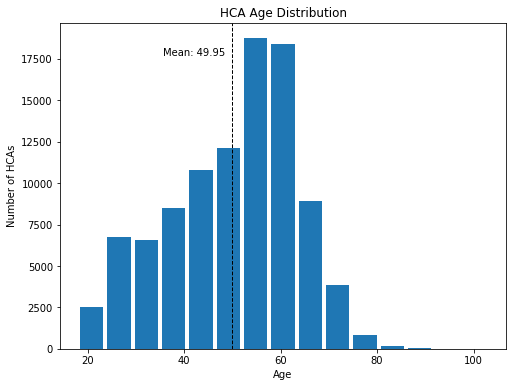

In [15]:
fig = plt.figure(figsize = (8, 6))
plt.hist(ages.Age, bins = 15, rwidth= 0.85, color='tab:blue')

# Add mean line
plt.axvline(ages.Age.mean(), color='k', linestyle='dashed', linewidth=1)
# Add mean line text
_, max_ = plt.ylim()
plt.text(ages.Age.mean() - ages.Age.mean()/3.5, 
         max_ - max_/10,
         'Mean: {:.2f}'.format(ages.Age.mean()))

plt.title('HCA Age Distribution')
plt.xlabel("Age")
plt.ylabel("Number of HCAs")
plt.show()

## What is the effect of gender, age, geography (urban/rural), and having one of our chronic conditions of interest on the likelihood of someone having a comorbidity?

The percentage of female HCAs with comorbidities is very similar to the percentage of male HCAs with comorbidities. __~46.6% of female HCAs__ have comorbidities and __~45% of male HCAs__ have comorbidiites.

In [20]:
def code_chronic_disease (group):
    df = pd.DataFrame()
    df['member_id'] = group.head(1)['member_id']
    df['gender'] = group.head(1)['gender']
    df['age'] = group['age'].max()
    df['urban_rural'] = group.head(1)['urban_rural']
    if any(group['flag_comorbidity'] == 1):
        df['chronic_disease'] = 2
    elif any(group['total_conditions'] == 1):
        df['chronic_disease'] = 1
    else:
        df['chronic_disease'] = 0
    return df

In [22]:
comorbid = med.groupby('member_id', as_index=False).apply(code_chronic_disease)

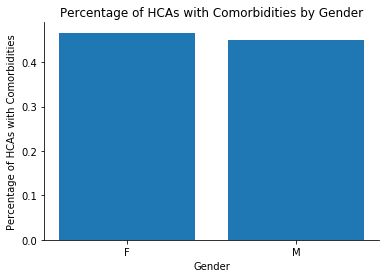

In [23]:
gender_comorbid = comorbid.loc[comorbid['chronic_disease'] == 2].groupby('gender').size()
gender = comorbid.groupby('gender').size()
gender_pct = gender_comorbid/gender

ax = plt.subplot()
ax.bar(gender_pct.index, gender_pct)
ax.set_xlabel('Gender')
ax.set_ylabel('Percentage of HCAs with Comorbidities')
ax.set_title('Percentage of HCAs with Comorbidities by Gender')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In order to look at age, we separated these into buckets. Since we start to see more chronic conditions after age 30, we chose to first create an age bucket of 18-29 year olds and continue in 10 year increments until age 70. We see that the percentage of HCAs with comorbidities increase as age increases. This is to be expected as we are more likely to develop more diseases as we get older.

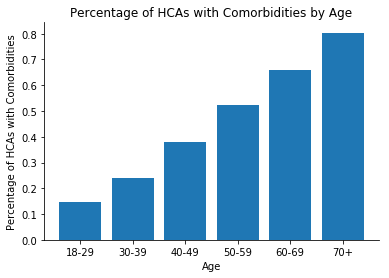

In [24]:
def age_buckets(row):
    age_bucket = ''
    if (row['age'] >= 18 and row['age'] <=29):
        age_bucket = '18-29'
    elif (row['age'] >= 30 and row['age'] <= 39):
        age_bucket = '30-39'
    elif (row['age'] >= 40 and row['age'] <= 49):
        age_bucket = '40-49'
    elif (row['age'] >= 50 and row['age'] <= 59):
        age_bucket = '50-59'
    elif (row['age'] >= 60 and row['age'] <= 69):
        age_bucket = '60-69'
    elif (row['age'] >= 70):
        age_bucket = '70+'
    return age_bucket

comorbid['age_bucket'] = comorbid.apply(age_buckets, axis=1)
age_comorbid = comorbid.loc[comorbid['chronic_disease'] == 2].groupby('age_bucket').size()
age = comorbid.groupby('age_bucket').size()
age_pct = age_comorbid/age

ax = plt.subplot()
ax.bar(age_pct.index, age_pct)
ax.set_xlabel('Age')
ax.set_ylabel('Percentage of HCAs with Comorbidities')
ax.set_title('Percentage of HCAs with Comorbidities by Age')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The percentage of HCAs living in urban areas with comorbidities is very similar to the percentage of HCAs living in rural areas with comorbidities. __~46.2% of HCAs in urban areas__ have comorbidities and __~48.6% of HCAs in rural areas__ have comorbidiites.

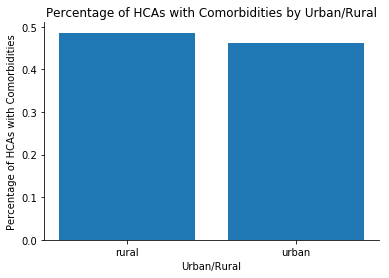

In [25]:
urban_rural_comorbid = comorbid.loc[comorbid['chronic_disease'] == 2].groupby('urban_rural').size()
urban_rural = comorbid.groupby('urban_rural').size()
urban_rural_pct = urban_rural_comorbid/urban_rural

ax = plt.subplot()
ax.bar(urban_rural_pct.index, urban_rural_pct)
ax.set_xlabel('Urban/Rural')
ax.set_ylabel('Percentage of HCAs with Comorbidities')
ax.set_title('Percentage of HCAs with Comorbidities by Urban/Rural')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Calculate the relationship between stability within the health insurance system (use member months) and its relationship to chronic disease rate 

### Using Kruskal-Wallis test (one-way ANOVA):
- Months of insurance coverage eligibility (member months per year) is the independent variable
- Binary variable (whether or not having a chronic disease) is the dependent variable
- The binary variable is being ranked and sorted into groups
- Analysis limited to people with at least one chronic condition

The relationship between stability within the health insurance system and chronic disease was significant (H-score: 33.41; p-value < 0.05).
Interpretation:
For all the chronic disease of interest, the number of eligibility months varied significantly between members with and without a chronic condition